# Session setup

## Libraries

In [1]:
# basic operations
import os
import re
import logging
import time
import pickle

# utilities
from pprint import pprint as pp

# data analysis/management/manipulation
import numpy as np
import pandas as pd
import sklearn

# text analysis
import gensim
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel  
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
'''
Uncomment the next two lines of code if you don't have a copy of the
Mallet software installed in your machine
'''
# ! wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip # * update if needed *
# ! unzip mallet-2.0.8.zip
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
import spacy
import en_core_web_lg

# multivariate analysis
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

# distance metrics
from scipy.spatial.distance import cosine

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyLDAvis
import pyLDAvis.gensim

## Options for dumping outcome to the screen

In [2]:
# data vis
%matplotlib inline

# send output to the screen
LINE = ''.join(['\n', 79 * '-', '\n'])

## Basic info about the notebook/session

In [3]:
# check libraries
print(' | '.join(['spaCy Version: %s' % (spacy.__version__),
                  'Gensim Version: %s' % (gensim.__version__),]),
      end=LINE)

# coding style
print('Coding style as per PEP8', '', end=LINE)

spaCy Version: 2.1.3 | Gensim Version: 3.7.2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Coding style as per PEP8 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Read data

In [375]:
# params
CWD = os.getcwd()
FOLDER = 'data'
FILE = 'lq_instances.csv'
LQ = pd.read_csv(os.path.join(CWD, FOLDER, FILE))

# Logging Gensim's output

In [376]:
LOG_FILE = os.path.join(CWD, FOLDER, 'log_%s.txt' % time.time())

logging.basicConfig(filename=LOG_FILE,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

# Basic data cleaning

In [377]:
# abstract not available in some instances
ABS_YES = LQ['abstract'] != '[No abstract available]' 

print(' | '.join(['Number of articles: %s' % len(LQ.loc[ABS_YES]),
                  'Other items (e.g., editorial notes): %s'
                  % (len(LQ) - len(LQ.loc[ABS_YES]))]),
      end=LINE)

# slice data
LQ = LQ.loc[ABS_YES]

# remove returns
LQ.loc[:, 'abstract'] = LQ['abstract'].str.replace('\n', '')

# remove copyright details
LQ.loc[:, 'abstract'] = LQ['abstract'].str.split('©').str.get(0)

# list of abstract
DOCS = [abstract.strip().lower() for abstract in LQ.abstract]

# hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

Number of articles: 1156 | Other items (e.g., editorial notes): 145
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Pass documents through spaCy's `nlp` pipeline

## Load language model

In [378]:
# load spaCy model 'web_lg'
nlp = en_core_web_lg.load()

## Expand on spaCy's stopwords

In [379]:
# params
CWD = CWD
FOLDER = FOLDER
FILE = 'my_stopwords.pickle'

# load my stopwords from pickle
with open(os.path.join(CWD, FOLDER, FILE), 'rb') as pipe:
    MY_STOPWORDS = pickle.load(pipe)

# expand on spaCy's stopwords 
for stopword in MY_STOPWORDS:
    nlp.vocab[stopword].is_stop = True

In [380]:
#TODO: these keywords have to be added to MY_STOPWORDS
MY_STOPWORDS = list(MY_STOPWORDS)
MY_STOPWORDS.append('include')
MY_STOPWORDS.append('hypothesis')
MY_STOPWORDS.append('level')
MY_STOPWORDS.append('hypotheses')

## Tokenize text

In [381]:
# filter text
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

## Take into account bi- and tri-grams

In [382]:
# get rid of common terms
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']

# find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=COMMON_TERMS)

# uncomment if bi-grammed, tokenized document is preferred
# DOCS_PHRASED = [BIGRAM[line] for line in DOCS_TOKENS]
DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# check nlp pipeline
print('',
      'Published abstract:', DOCS[0],
      'Tokenized abstract:', DOCS_TOKENS[0],
      'Tri-grammed tokenised abstract:', DOCS_PHRASED[0],
      sep=LINE, end=LINE)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Published abstract:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for some time, it has been argued that stories articulated by leaders are an important vehicle for exercising influence, but stories of leadership might also serve as a means for developing leadership potential. one critical activity involved in leadership is vision formation, which involves constructing and communicating a future state that guides followers in “making sense” of complex organizational events. like leader visions, analyzing stories also, by nature, evokes sensemaking processes. as a result, analyzing stories of leadership may provide a natural means for practicing the art of sensemaking. in the present investigation, undergraduates were asked to read six short stories about incidents of either pragmatic or charismatic leadership in business settings. after reading each story, questions were a

# Topic modeling

## Model building

### Text transformation

In [383]:
# create dictionary and text corpus
'''
overriding these transformations breaks reproducibility
'''
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

### Mallet's implementation of LDA algorithm (using Gibbs sampling)

In [384]:
'''
Based on Gardner et al's LQ paper, we expect to see
29 distinctive topics circa
'''
N_TOPICS = 29
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=5)

[(0,
  '0.140*"development" + 0.023*"special" + 0.022*"developmental" + 0.021*"multi_level" + 0.017*"primarily"'),
 (1,
  '0.058*"context" + 0.046*"effective" + 0.039*"develop" + 0.031*"career" + 0.025*"set"'),
 (2,
  '0.067*"ethical" + 0.048*"moral" + 0.047*"goal" + 0.037*"consequence" + 0.036*"identify"'),
 (3,
  '0.059*"context" + 0.057*"type" + 0.033*"event" + 0.032*"environment" + 0.032*"specific"'),
 (4,
  '0.111*"lmx" + 0.060*"quality" + 0.042*"exchange" + 0.042*"strong" + 0.034*"relational"'),
 (5,
  '0.082*"practice" + 0.052*"management" + 0.033*"challenge" + 0.029*"public" + 0.024*"importance"'),
 (6,
  '0.161*"work" + 0.051*"network" + 0.047*"structure" + 0.039*"idea" + 0.026*"direct"'),
 (7,
  '0.149*"employee" + 0.096*"subordinate" + 0.065*"job" + 0.063*"supervisor" + 0.043*"satisfaction"'),
 (8,
  '0.097*"manager" + 0.038*"culture" + 0.030*"difference" + 0.027*"compare" + 0.027*"subordinate"'),
 (9,
  '0.089*"role" + 0.053*"emergence" + 0.052*"ability" + 0.048*"personalit

##  Model evaluation

### Get range of coherence values as the number of retained topics change

In [385]:
# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = MALLET_PATH
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [386]:
# collect coherence scores as the number of retained topics change
LIMIT, START, STEP = 40, 1, 1
MODEL_LIST, COHER_VALS = compute_coherence_values(dictionary=DICT,
                                                  corpus=CORPUS,
                                                  texts=DOCS_PHRASED,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

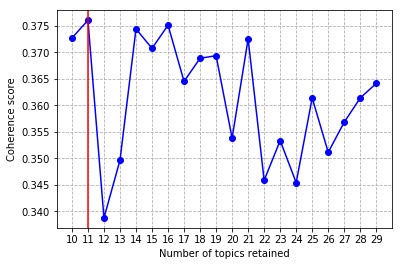

In [387]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS

# create figure
FIG = plt.figure(figsize=(6, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(10, 30, 1))

# reference line
AX.axvline(x=11, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')

# save plot to file
CWD = CWD
FOLDER = 'exhibits/appxB'
FILE = 'B_0.pdf'
plt.savefig(os.path.join(CWD, FOLDER, FILE),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

plt.show()

In [388]:
# suggested number of topics to retain -- see above
N_TOPICS = 10

# model estimation
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)

# print results
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=10)

[(0,
  '0.042*"context" + 0.030*"woman" + 0.024*"difference" + 0.024*"power" + 0.020*"role" + 0.017*"gender" + 0.017*"practice" + 0.016*"female" + 0.013*"culture" + 0.012*"position"'),
 (1,
  '0.034*"perception" + 0.033*"affect" + 0.030*"role" + 0.028*"emotion" + 0.028*"positive" + 0.026*"emotional" + 0.026*"negative" + 0.017*"network" + 0.016*"influence" + 0.016*"collective"'),
 (2,
  '0.056*"transformational" + 0.043*"subordinate" + 0.026*"rating" + 0.021*"trait" + 0.017*"associate" + 0.016*"experience" + 0.016*"significant" + 0.016*"personality" + 0.014*"high" + 0.014*"analysis"'),
 (3,
  '0.046*"development" + 0.027*"perspective" + 0.017*"develop" + 0.015*"political" + 0.015*"include" + 0.013*"purpose" + 0.013*"interest" + 0.012*"view" + 0.012*"multiple" + 0.010*"year"'),
 (4,
  '0.054*"employee" + 0.048*"work" + 0.034*"lmx" + 0.023*"job" + 0.023*"supervisor" + 0.021*"perceive" + 0.019*"authentic" + 0.018*"mediate" + 0.016*"hypothesis" + 0.015*"satisfaction"'),
 (5,
  '0.024*"under

### Result visualization with pyLDAvis

### Copy the training model weights from `Mallet` to `Gensim`

In [389]:
# translate topic modeling outcome
LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)

In [390]:
# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.gensim.prepare(LDA_MALLET_G, CORPUS, DICT, sort_topics=False)
DATA_VIS

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.137176 -0.073134       1        1   9.868051
1     -0.098397  0.137931       2        1   9.696344
2     -0.130300 -0.226149       3        1  10.486971
3      0.297407  0.084309       4        1  10.138615
4     -0.144736  0.158053       5        1  10.418150
5     -0.045599  0.244126       6        1  10.001669
6     -0.082241 -0.151466       7        1  10.110474
7      0.225939  0.011279       8        1   9.562007
8      0.022695 -0.222757       9        1   9.681441
9     -0.181944  0.037809      10        1  10.036278, topic_info=     Category        Freq              Term       Total  loglift  logprob
89    Default  701.000000       performance  701.000000  30.0000  30.0000
221   Default  565.000000              team  565.000000  29.0000  29.0000
157   Default  480.000000             group  480.000000  28.0000  28.0000
324   Default  420.000000  transformational  420.000000  27.0000  27.0000
74    Default  367.000000          employee  367.000000  26.0000  26.0000
7     Default  325.000000       charismatic  325.000000  25.0000  25.0000
101   Default  383.000000              work  383.000000  24.0000  24.0000
13    Default  303.000000       development  303.000000  23.0000  23.0000
609   Default  298.000000       subordinate  298.000000  22.0000  22.0000
110   Default  269.000000           context  269.000000  21.0000  21.0000
280   Default  263.000000     effectiveness  263.000000  20.0000  20.0000
109   Default  258.000000            change  258.000000  19.0000  19.0000
170   Default  410.000000              role  410.000000  18.0000  18.0000
127   Default  219.000000           manager  219.000000  17.0000  17.0000
299   Default  231.000000               lmx  231.000000  16.0000  16.0000
631   Default  218.000000            member  218.000000  15.0000  15.0000
88    Default  272.000000        perception  272.000000  14.0000  14.0000
615   Default  208.000000            affect  208.000000  13.0000  13.0000
1167  Default  200.000000               ceo  200.000000  12.0000  12.0000
50    Default  199.000000              task  199.000000  11.0000  11.0000
176   Default  195.000000             woman  195.000000  10.0000  10.0000
51    Default  190.000000              time  190.000000   9.0000   9.0000
92    Default  238.000000          positive  238.000000   8.0000   8.0000
14    Default  179.000000           emotion  179.000000   7.0000   7.0000
600   Default  239.000000             level  239.000000   6.0000   6.0000
239   Default  190.000000       perspective  190.000000   5.0000   5.0000
994   Default  176.000000            rating  176.000000   4.0000   4.0000
937   Default  164.000000         emotional  164.000000   3.0000   3.0000
12    Default  234.000000           develop  234.000000   2.0000   2.0000
1051  Default  159.000000          charisma  159.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
169   Topic10  100.075957          response  101.143500   2.2884  -4.1847
295   Topic10   34.763227       independent   34.763227   2.2990  -5.2421
2519  Topic10   33.709796      extraversion   33.709796   2.2990  -5.2728
1824  Topic10   32.656365          complete   32.656365   2.2990  -5.3046
1504  Topic10   32.656365         dominance   32.656365   2.2990  -5.3046
1548  Topic10   31.602934             score   31.602934   2.2990  -5.3374
967   Topic10   31.602934         selection   31.602934   2.2990  -5.3374
2040  Topic10   30.549503             ideal   30.549503   2.2990  -5.3713
2632  Topic10   30.549503              norm   30.549503   2.2990  -5.3713
3378  Topic10   29.496071          efficacy   29.496071   2.2990  -5.4064
905   Topic10   29.496071   decision_making   29.496071   2.2990  -5.4064
2353  Topic10   28.442640     self_efficacy   28.442640   2.2990  -5.4427
76    Topic10   65.312730      experimental   67.4761

In [391]:
# save pyLDAvis data to json file
pyLDAvis.save_json(DATA_VIS, 'topic_modelling_vis.json')

### Get term-to-topic probabilities

In [392]:
# get top 5 terms per topic
TOP_TERMS_LINE = LDA_MALLET_G.show_topics(num_topics=N_TOPICS, num_words=10)

In [393]:
# rearrange data on top 10 terms per topic
TOP_TERMS_M = []

for i in TOP_TERMS_LINE:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        TOP_TERMS_M.append([topic_num, term_sort, weight, term])

DF = pd.DataFrame(TOP_TERMS_M)

# rename columns
OLD_NAMES = [0, 1, 2, 3]
NEW_NAMES = ['topic_n', 'term_sort', 'weight', 'term']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)
DF.set_index(['term_sort', 'topic_n'], inplace=True)
DF = DF.unstack()

# sidewaystable
DF_H = pd.DataFrame()

for i in range(10):
    terms = DF['term'][i]
    weights = DF['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights ])
    DF_H = pd.concat([DF_H, terms, weights], axis=1)


# write data to file
CWD = CWD
FOLDER = 'exhibits'
FILE = '_1.tex'
DF_H.T.to_latex(os.path.join(CWD, FOLDER, FILE), index=True)

### Get document-to-topic probabilities

In [394]:
# get transformed corpus as per the LDA model
TRANSF_CORPUS = LDA_MALLET_G.get_document_topics(CORPUS)

# rearrange data on document-topic pairs probabilities
DOC_TOPIC_M = []

for id, doc in enumerate(TRANSF_CORPUS):
    for topic in np.arange(0, 10, 1):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1] 
        DOC_TOPIC_M.append([id, topic, topic_prob])

DF = pd.DataFrame(DOC_TOPIC_M)

# rename columns
OLD_NAMES = [0, 1, 2]
NEW_NAMES = ['doc_id', 'topic_n', 'prob']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)

# dominant topic
GR = DF.groupby('doc_id')
DF.loc[:, 'max'] = GR['prob'].transform(np.max)
DF.loc[:, 'first_topic'] = 0
DF.loc[DF['prob'] == DF['max'], 'first_topic'] = 1
FIRST_TOPIC = DF.loc[DF['first_topic'] == 1]

# arrange data as contingency table
DF = DF.pivot_table(index='doc_id', columns='topic_n', values='prob', aggfunc=np.mean)

# write data to file
CWD = CWD
FOLDER = 'transformed_data'
FILE = 'transformed_corpus.csv'
DF.to_csv(os.path.join(CWD, FOLDER, FILE), index=True)

### Multidimensional Scaling on the Transformed Corpus

In [395]:
# center features (doc-topic probabilities) data
X = DF.values
X -= X.mean()

# get similarity matrix
SIMS = euclidean_distances(X)

# mds model
SEED = np.random.seed(123)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=SEED,
                   dissimilarity="precomputed", n_jobs=1)

# get MDS positions
POS = mds.fit(SIMS).embedding_

# get data frame
POS = pd.DataFrame(POS, columns=('x1', 'x2'))
POS.loc[:, 'doc_id'] = np.arange(0, len(DF))

# merge MDS positions and most important topic by document
POS = pd.merge(POS, FIRST_TOPIC[['doc_id', 'topic_n']], on='doc_id', how='inner')

# write data to file
CWD = CWD
FOLDER = 'transformed_data'
FILE = 'mds_positions.csv'
POS.to_csv(os.path.join(CWD, FOLDER, FILE), index=False)

# Pre-process abstracts on natural experiments

## Read abstracts

In [688]:
# sample of NE articles in the field of leadership
CWD = CWD
FOLDER = 'data'
FILE_0 = 'ne_in_ldr.csv' 
NE_0 = pd.read_csv(os.path.join(CWD, FOLDER, FILE_0))

# info
print(NE_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 5 columns):
id                        87 non-null int64
gardner_et_al_2010_cat    87 non-null object
standard_ne               87 non-null int64
iv                        87 non-null int64
rdd                       87 non-null int64
dtypes: int64(4), object(1)
memory usage: 3.5+ KB
None


In [689]:
# population of NE articles
'''
Articles cut across the `business & management,'
`economics,' `multidiciplinary,' `psychology,' and
`social sciences' categories as per Scopus
'''
CWD = CWD
FILE_1 = 'ne_instances.csv'
NE_1 = pd.read_csv(os.path.join(CWD, FOLDER, FILE_1))

# info
print(NE_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6922 entries, 0 to 6921
Data columns (total 16 columns):
id                 6922 non-null int64
authors            6922 non-null object
title              6922 non-null object
journal            6922 non-null object
year               6922 non-null int64
abstract           6922 non-null object
keywords           5134 non-null object
scopus_keywords    2690 non-null object
link               6922 non-null object
count              6922 non-null int64
sort               6922 non-null int64
busman             6922 non-null int64
econ               6922 non-null int64
mult               6922 non-null int64
psych              6922 non-null int64
socsci             6922 non-null int64
dtypes: int64(9), object(7)
memory usage: 865.3+ KB
None


In [690]:
# merge
NE = pd.merge(NE_0, NE_1[['id', 'abstract', 'authors', 'year']],
              on='id', how='left')

print(NE.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 86
Data columns (total 8 columns):
id                        87 non-null int64
gardner_et_al_2010_cat    87 non-null object
standard_ne               87 non-null int64
iv                        87 non-null int64
rdd                       87 non-null int64
abstract                  87 non-null object
authors                   87 non-null object
year                      87 non-null int64
dtypes: int64(5), object(3)
memory usage: 6.1+ KB
None


## Basic data cleaning

In [691]:
# abstract not available in some instances
ABS_YES = NE['abstract'] != '[No abstract available]' 

print(' | '.join(['Number of articles: %s' % len(NE.loc[ABS_YES]),
                  'Other items (e.g., editorial notes): %s'
                  % (len(NE) - len(NE.loc[ABS_YES]))]),
      end=LINE)

# slice data
NE = NE.loc[ABS_YES]

# remove returns
NE.loc[:, 'abstract'] = NE['abstract'].str.replace('\n', '')

# remove copyright details
SPLIT_ON = '©'
NE.loc[:, 'abstract'] = NE['abstract'].str.split(SPLIT_ON).str.get(0)


# list of abstract
NEW_DOCS = [abstract.strip().lower() for abstract in NE.abstract]

# hyphen to underscores
'''
converting '-' to '_' to make sure that terms
are not split up during subsequent Gensim and 
Textacy manipulation.
'''
NEW_DOCS = [re.sub(r'\b-\b', '_', text) for text in NEW_DOCS]

Number of articles: 87 | Other items (e.g., editorial notes): 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## NLP pipeline

In [692]:
# filter text
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in NEW_DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

## Take into account bi- and tri-grams

In [693]:
DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# check nlp pipeline
print('',
      'Published abstract:', DOCS[0],
      'Tokenized abstract:', DOCS_TOKENS[0],
      'Tri-grammed tokenised abstract:', DOCS_PHRASED[0],
      sep=LINE, end=LINE)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Published abstract:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for some time, it has been argued that stories articulated by leaders are an important vehicle for exercising influence, but stories of leadership might also serve as a means for developing leadership potential. one critical activity involved in leadership is vision formation, which involves constructing and communicating a future state that guides followers in “making sense” of complex organizational events. like leader visions, analyzing stories also, by nature, evokes sensemaking processes. as a result, analyzing stories of leadership may provide a natural means for practicing the art of sensemaking. in the present investigation, undergraduates were asked to read six short stories about incidents of either pragmatic or charismatic leadership in business settings. after reading each story, questions were a

## Text transformation

In [694]:
NEW_CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

# Folding new documents in the LDA model

In [695]:
# get transformed corpus as per the LDA model
TRANSF_CORPUS = LDA_MALLET_G.get_document_topics(NEW_CORPUS)

# rearrange data on document-topic pairs probabilities
DOC_TOPIC_M = []

for id, doc in enumerate(TRANSF_CORPUS):
    for topic in np.arange(0, 10, 1):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1] 
        DOC_TOPIC_M.append([id, topic, topic_prob])

DF = pd.DataFrame(DOC_TOPIC_M)

# rename columns
OLD_NAMES = [0, 1, 2]
NEW_NAMES = ['ne_study_id', 'topic_n', 'prob']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)

## Assemble descriptive tables to export

In [696]:
# salient topcis
DF.set_index('ne_study_id', inplace=True)
DF.sort_values('prob', ascending=False, inplace=True)
DF.loc[:, 'topic_sort'] = 1
GR = DF.groupby(level=['ne_study_id'])
DF.loc[:, 'topic_sort'] = GR['topic_sort'].transform(np.cumsum)
SL = DF.loc[DF['topic_sort'] <= 3]

# index
SL.reset_index(inplace=True)
SL.set_index(['ne_study_id', 'topic_sort'], inplace=True)


# unstack
SL = SL.unstack(level=(-1))

# get study attributes
NE.loc[:, 'ne_study_id'] = np.arange(0, len(NE), 1)
NE.set_index('ne_study_id', inplace=True)
SL = pd.merge(SL, NE[['authors', 'year',
                        'standard_ne', 'iv', 'rdd']],
              left_index=True, right_index=True,
              how='left')


# set of authors
AUTHORS = [i for i in SL['authors']]

# format names
AUTHOR_COL, TMP = [], []

for sort, i in enumerate(AUTHORS):
    author_split = i.split(',')
    for j in author_split:
        to_append = j.strip().split(' ')[0]
        TMP.append(to_append)
    AUTHOR_COL.append([sort, TMP])
    TMP = []

AUTHORS = []

for i in AUTHOR_COL:
    names = i[1]
    if len(names) == 1:
        AUTHORS.append(names[0])
    elif len(names) == 2:
        AUTHORS.append(' & '.join([names[0], names[1]]))
    elif len(names) > 2:
        AUTHORS.append(names[0] + ' et al.')
    else:
        pass

SL.loc[:, 'authors'] = AUTHORS

# short reference
SL.loc[:, 'ref'] = (SL['authors'] +  ' (' + SL['year'].astype(str) + ')')

# arrange columns
SL.reset_index(inplace=True)
SL = SL.loc[:, ['ne_study_id', 'ref', 
                'standard_ne', 'iv', 'rdd',
                ('topic_n', 1), ('prob', 1),
                ('topic_n', 2), ('prob', 2),
                ('topic_n', 3), ('prob', 3)]]

# format numbers
COLS = [('prob', 1), ('prob', 2), ('prob', 3)]
SL[COLS] = SL.loc[:, COLS].apply(lambda x: np.round(x, 3))

# write study - salient topic to files
CWD = CWD
FOLDER = 'exhibits'

# standard natural experiments 
FILE = '_2.tex' 
SNE = SL.loc[SL['standard_ne'] == 1]
SNE.sort_values('ref', ascending=True, inplace=True)
COLS = ['ref', 
        ('topic_n', 1), ('prob', 1),
        ('topic_n', 2), ('prob', 2),
        ('topic_n', 3), ('prob', 3)]
SNE_TAB = SNE[COLS]



for column in SNE_TAB.columns[1:]:
    SNE_TAB.loc[SNE_TAB[column] == 0, column] = 'Female leadership'
    SNE_TAB.loc[SNE_TAB[column] == 1, column] = 'Emotions and leadership'
    SNE_TAB.loc[SNE_TAB[column] == 2, column] = 'Transformational leadership'
    SNE_TAB.loc[SNE_TAB[column] == 3, column] = 'Development of leadership'
    SNE_TAB.loc[SNE_TAB[column] == 4, column] = 'Dyadic relations'
    SNE_TAB.loc[SNE_TAB[column] == 5, column] = 'Cognition and leadership'
    SNE_TAB.loc[SNE_TAB[column] == 6, column] = 'Strategic leadership'
    SNE_TAB.loc[SNE_TAB[column] == 7, column] = 'Ethical leadership'
    SNE_TAB.loc[SNE_TAB[column] == 8, column] = 'Charismatic leadership'
    SNE_TAB.loc[SNE_TAB[column] == 9, column] = 'Leadership in teams and decision groups'
    
SNE_TAB.to_latex(os.path.join(CWD, FOLDER, FILE))

In [708]:


# iv
CWD = CWD
FILE = '_3.tex' 
IV = SL.loc[SL['iv'] == 1]
IV.sort_values('ref', ascending=True, inplace=True)
COLS = ['ref', 
        ('topic_n', 1), ('prob', 1),
        ('topic_n', 2), ('prob', 2),
        ('topic_n', 3), ('prob', 3)]
IV[COLS].to_latex(os.path.join(CWD, FOLDER, FILE))

IV_TAB = IV[COLS]

for column in IV_TAB.columns[1:]:
    IV_TAB.loc[IV_TAB[column] == 0,  column] = 'Female leadership'
    IV_TAB.loc[IV_TAB[column] == 1,  column] = 'Emotions and leadership'
    IV_TAB.loc[IV_TAB[column] == 2,  column] = 'Transformational leadership'
    IV_TAB.loc[IV_TAB[column] == 3,  column] = 'Development of leadership'
    IV_TAB.loc[IV_TAB[column] == 4,  column] = 'Dyadic relations'
    IV_TAB.loc[IV_TAB[column] == 5,  column] = 'Cognition and leadership'
    IV_TAB.loc[IV_TAB[column] == 6,  column] = 'Strategic leadership'
    IV_TAB.loc[IV_TAB[column] == 7,  column] = 'Ethical leadership'
    IV_TAB.loc[IV_TAB[column] == 8,  column] = 'Charismatic leadership'
    IV_TAB.loc[IV_TAB[column] == 9,  column] = 'Leadership in teams and decision groups'
    
IV_TAB.to_latex(os.path.join(CWD, FOLDER, FILE))

# rdd
FILE = '_4.tex' 
RDD = SL.loc[SL['rdd'] == 1]
RDD.sort_values('ref', ascending=True, inplace=True)
COLS = ['ref', 
        ('topic_n', 1), ('prob', 1),
        ('topic_n', 2), ('prob', 2),
        ('topic_n', 3), ('prob', 3)]
RDD_TAB = RDD[COLS]

for column in RDD_TAB.columns[1:]:
    RDD_TAB.loc[RDD_TAB[column] == 0,  column] = 'Female leadership'
    RDD_TAB.loc[RDD_TAB[column] == 1,  column] = 'Emotions and leadership'
    RDD_TAB.loc[RDD_TAB[column] == 2,  column] = 'Transformational leadership'
    RDD_TAB.loc[RDD_TAB[column] == 3,  column] = 'Development of leadership'
    RDD_TAB.loc[RDD_TAB[column] == 4,  column] = 'Dyadic relations'
    RDD_TAB.loc[RDD_TAB[column] == 5,  column] = 'Cognition and leadership'
    RDD_TAB.loc[RDD_TAB[column] == 6,  column] = 'Strategic leadership'
    RDD_TAB.loc[RDD_TAB[column] == 7,  column] = 'Ethical leadership'
    RDD_TAB.loc[RDD_TAB[column] == 8,  column] = 'Charismatic leadership'
    RDD_TAB.loc[RDD_TAB[column] == 9,  column] = 'Leadership in teams and decision groups'
    
RDD_TAB.to_latex(os.path.join(CWD, FOLDER, FILE))

# Statistical analysis

## Update MDS with folded-in documents

In [ ]:
# read data on document-topic pairs from files
CWD = CWD
FOLDER = 'transformed_data'

FILE = 'transformed_newdocs.csv'
DF0 = pd.read_csv(os.path.join(CWD, FOLDER, FILE))
DF0.loc[:, 'training_set'] = 0 

FILE = 'transformed_corpus.csv'
DF1 = pd.read_csv(os.path.join(CWD, FOLDER, FILE))
DF1.loc[:, 'training_set'] = 1

# arrange data
COLS = ['%s' %i for i in np.arange(0, N_TOPICS, 1)]
COLS.append('training_set')

SNE = SNE.loc[SNE['ne_study_id'] != '']
MDS_SNE = pd.merge(DF0, SNE[['ne_study_id']], on='ne_study_id', how='right')
MDS_SNE = pd.concat([MDS_SNE[COLS], DF1[COLS]])

IV = IV.loc[IV['ne_study_id'] != '']
MDS_IV = pd.merge(DF0, IV[['ne_study_id']], on='ne_study_id', how='right')
MDS_IV = pd.concat([MDS_IV[COLS], DF1[COLS]])

RDD = RDD.loc[RDD['ne_study_id'] != '']
MDS_RDD = pd.merge(DF0, RDD[['ne_study_id']], on='ne_study_id', how='right')
MDS_RDD = pd.concat([MDS_RDD[COLS], DF1[COLS]])

# load previous estimates
CWD = CWD
FOLDER = 'transformed_data'
FILE = 'mds_positions.csv'
MDS = pd.read_csv(os.path.join(CWD, FOLDER, FILE))
MDS.loc[:, 'topic_n'] = MDS['topic_n'] + 1

## Standard NE form

### Update MDS estimation

In [634]:
# center features (doc-topic probabilities) data
MDS_SNE.set_index('training_set', inplace=True)
INDEX = MDS_SNE.index

# values
X = MDS_SNE.values
X -= X.mean()

# get similarity matrix
SIMS = euclidean_distances(X)

# mds model
SEED = np.random.seed(123)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=SEED,
                   dissimilarity="precomputed", n_jobs=1)

# get MDS positions
MDS_SNE = mds.fit(SIMS).embedding_

# get data frame
MDS_SNE = pd.DataFrame(MDS_SNE, columns=('x1', 'x2'))
MDS_SNE.loc[:, 'training_set'] = INDEX

# merge MDS positions and most important topic by document
# POS = pd.merge(POS, FIRST_TOPIC[['doc_id', 'topic_n']], on='doc_id', how='inner')

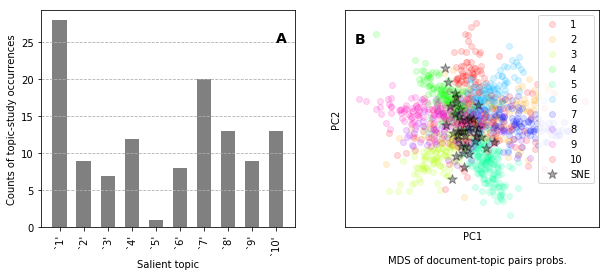

In [635]:
# create figure
FIG, [AX0, AX1] = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# panel A: distribution of dominant topics
X = pd.concat([SNE[('topic_n', 1)], SNE[('topic_n', 2)],
               SNE[('topic_n', 3)]])
SL_TS, COUNTS = np.unique(X, return_counts=True)
POS = np.arange(0, len(SL_TS), 1)

# panel B: MDS
UNIQUE_TOPICS = np.arange(1, N_TOPICS + 1, 1)
CMAP = cm.hsv(np.linspace(0, 1, len(UNIQUE_TOPICS)))
X1 = MDS_SNE.loc[MDS_SNE['training_set'] == 0, 'x1']
X2 = MDS_SNE.loc[MDS_SNE['training_set'] == 0, 'x2']

# panel A: plot dat
AX0.bar(POS, COUNTS, color='grey', width=0.6)
AX0.set_xticks(POS) 
LABELS = ['`%s\'' % i for i in SL_TS + 1]
AX0.set_xticklabels(LABELS, rotation='vertical')
AX0.set_xlabel('Salient topic')
AX0.set_ylabel('Counts of topic-study occurrences')
AX0.grid(axis='y', ls='--')
AX0.text(9, 25, 'A', fontweight='bold', fontsize=14, color='k')
# AX0.text(0, -8, 'Timespan: 2000 - $1^{st}$ Quarter of 2019')

# panel B: plot data
LABELS = ['%s' % i for i in np.arange(1, N_TOPICS + 1, 1)]
for topic, label, color in zip(UNIQUE_TOPICS, LABELS, CMAP):
    x1 = MDS.loc[MDS['topic_n'] == topic, 'x1']
    x2 = MDS.loc[MDS['topic_n'] == topic, 'x2']
    AX1.scatter(x1, x2, color=color, alpha=0.15,
                label=label)

AX1.scatter(X1, X2, color='black', alpha=0.35,
            marker='*', s=100,
            label='SNE')
    
# annotation
AX1.text(-0.42, 0.345, 'B', fontweight='bold', fontsize=14, color='k')
AX1.text(-0.3, -0.61, 'MDS of document-topic pairs probs.',
         color='k')


# axes
AX1.set_xlabel('PC1')
AX1.set_ylabel('PC2')
AX1.set_xticks([])
AX1.set_yticks([])

# lower
AX1.legend(loc='best')

# save plot to file
CWD = CWD
FOLDER = 'exhibits'
FILE = '_1.pdf'
plt.savefig(os.path.join(CWD, FOLDER, FILE),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

# send plot to the screen
plt.show()

## IV form

### Update MDS estimation

In [636]:
# center features (doc-topic probabilities) data
MDS_IV.set_index('training_set', inplace=True)
INDEX = MDS_IV.index

# values
X = MDS_IV.values
X -= X.mean()

# get similarity matrix
SIMS = euclidean_distances(X)

# mds model
SEED = np.random.seed(123)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=SEED,
                   dissimilarity="precomputed", n_jobs=1)

# get MDS positions
MDS_IV = mds.fit(SIMS).embedding_

# get data frame
MDS_IV = pd.DataFrame(MDS_IV, columns=('x1', 'x2'))
MDS_IV.loc[:, 'training_set'] = INDEX

# merge MDS positions and most important topic by document
# POS = pd.merge(POS, FIRST_TOPIC[['doc_id', 'topic_n']], on='doc_id', how='inner')

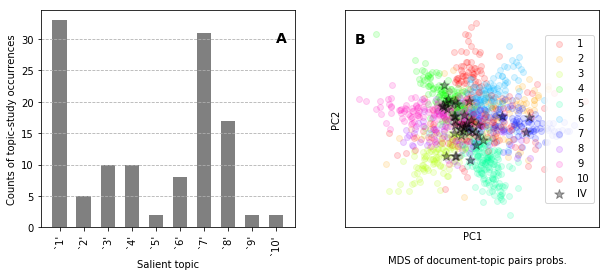

In [637]:
# create figure
FIG, [AX0, AX1] = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# panel A: distribution of dominant topics
X = pd.concat([IV[('topic_n', 1)], IV[('topic_n', 2)],
               IV[('topic_n', 3)]])
SL_TS, COUNTS = np.unique(X, return_counts=True)
POS = np.arange(0, len(SL_TS), 1)

# panel B: MDS
UNIQUE_TOPICS = np.arange(1, N_TOPICS + 1, 1)
CMAP = cm.hsv(np.linspace(0, 1, len(UNIQUE_TOPICS)))
X1 = MDS_IV.loc[MDS_IV['training_set'] == 0, 'x1']
X2 = MDS_IV.loc[MDS_IV['training_set'] == 0, 'x2']

# panel A: plot dat
AX0.bar(POS, COUNTS, color='grey', width=0.6)
AX0.set_xticks(POS) 
LABELS = ['`%s\'' % i for i in SL_TS + 1]
AX0.set_xticklabels(LABELS, rotation='vertical')
AX0.set_xlabel('Salient topic')
AX0.set_ylabel('Counts of topic-study occurrences')
AX0.grid(axis='y', ls='--')
AX0.text(9, 29.5, 'A', fontweight='bold', fontsize=14, color='k')
# AX0.text(0, -8, 'Timespan: 2000 - $1^{st}$ Quarter of 2019')

# panel B: plot data
LABELS = ['%s' % i for i in np.arange(1, N_TOPICS + 1, 1)]
for topic, label, color in zip(UNIQUE_TOPICS, LABELS, CMAP):
    x1 = MDS.loc[MDS['topic_n'] == topic, 'x1']
    x2 = MDS.loc[MDS['topic_n'] == topic, 'x2']
    AX1.scatter(x1, x2, color=color, alpha=0.15,
                label=label)

AX1.scatter(X1, X2, color='black', alpha=0.35,
            marker='*', s=100,
            label='IV')
    
# annotation
AX1.text(-0.42, 0.345, 'B', fontweight='bold', fontsize=14, color='k')
AX1.text(-0.3, -0.61, 'MDS of document-topic pairs probs.',
         color='k')


# axes
AX1.set_xlabel('PC1')
AX1.set_ylabel('PC2')
AX1.set_xticks([])
AX1.set_yticks([])

# lower
AX1.legend(loc='right')

# save plot to file
CWD = CWD
FOLDER = 'exhibits'
FILE = '_2.pdf'
plt.savefig(os.path.join(CWD, FOLDER, FILE),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

# send plot to the screen
plt.show()

## RDD form

### Update MDS estimation

In [638]:
# center features (doc-topic probabilities) data
MDS_RDD.set_index('training_set', inplace=True)
INDEX = MDS_RDD.index

# values
X = MDS_RDD.values
X -= X.mean()

# get similarity matrix
SIMS = euclidean_distances(X)

# mds model
SEED = np.random.seed(123)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=SEED,
                   dissimilarity="precomputed", n_jobs=1)

# get MDS positions
MDS_RDD = mds.fit(SIMS).embedding_

# get data frame
MDS_RDD = pd.DataFrame(MDS_RDD, columns=('x1', 'x2'))
MDS_RDD.loc[:, 'training_set'] = INDEX

# merge MDS positions and most important topic by document
# POS = pd.merge(POS, FIRST_TOPIC[['doc_id', 'topic_n']], on='doc_id', how='inner')

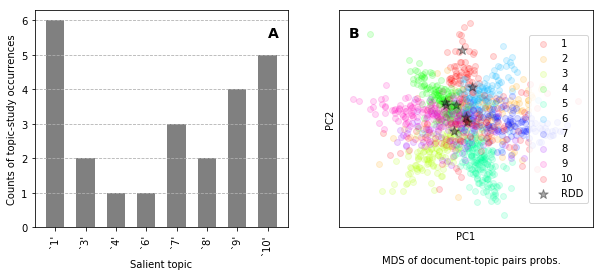

In [639]:
# create figure
FIG, [AX0, AX1] = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# panel A: distribution of dominant topics
X = pd.concat([RDD[('topic_n', 1)], RDD[('topic_n', 2)],
               RDD[('topic_n', 3)]])
SL_TS, COUNTS = np.unique(X, return_counts=True)
POS = np.arange(0, len(SL_TS), 1)

# panel B: MDS
UNIQUE_TOPICS = np.arange(1, N_TOPICS + 1, 1)
CMAP = cm.hsv(np.linspace(0, 1, len(UNIQUE_TOPICS)))
X1 = MDS_RDD.loc[MDS_RDD['training_set'] == 0, 'x1']
X2 = MDS_RDD.loc[MDS_RDD['training_set'] == 0, 'x2']

# panel A: plot dat
AX0.bar(POS, COUNTS, color='grey', width=0.6)
AX0.set_xticks(POS) 
LABELS = ['`%s\'' % i for i in SL_TS + 1]
AX0.set_xticklabels(LABELS, rotation='vertical')
AX0.set_xlabel('Salient topic')
AX0.set_ylabel('Counts of topic-study occurrences')
AX0.grid(axis='y', ls='--')
AX0.text(7, 5.5, 'A', fontweight='bold', fontsize=14, color='k')
# AX0.text(0, -8, 'Timespan: 2000 - $1^{st}$ Quarter of 2019')

# panel B: plot data
LABELS = ['%s' % i for i in np.arange(1, N_TOPICS + 1, 1)]
for topic, label, color in zip(UNIQUE_TOPICS, LABELS, CMAP):
    x1 = MDS.loc[MDS['topic_n'] == topic, 'x1']
    x2 = MDS.loc[MDS['topic_n'] == topic, 'x2']
    AX1.scatter(x1, x2, color=color, alpha=0.15,
                label=label)

AX1.scatter(X1, X2, color='black', alpha=0.35,
            marker='*', s=100,
            label='RDD')
    
# annotation
AX1.text(-0.42, 0.37, 'B', fontweight='bold', fontsize=14, color='k')
AX1.text(-0.3, -0.61, 'MDS of document-topic pairs probs.',
         color='k')


# axes
AX1.set_xlabel('PC1')
AX1.set_ylabel('PC2')
AX1.set_xticks([])
AX1.set_yticks([])

# lower
AX1.legend(loc='right')

# save plot to file
CWD = CWD
FOLDER = 'exhibits'
FILE = '_3.pdf'
plt.savefig(os.path.join(, FOLDER, FILE),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

# send plot to the screen
plt.show()